In [2]:
! pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 1.2 MB/s eta 0:00:00
     ------------------------------------ 420.6/420.6 kB 656.6 kB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 14.7/14.7 MB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 2.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.5 which is incompatible.
conda-repo-cli 1.0.27 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.27 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.27 requires requests==2.28.1, but you have requests 2.28.2 which is incompatible.
anaconda-client 1.11.0 requires urllib3>=1.26.4, but you have urllib3 1.22 which is incompatible.


In [39]:
! pip install pydot
! pip install scikeras

In [83]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from keras.utils import to_categorical

import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv('melbourne-housing-dataset-trunc.csv')

In [85]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['encoded_suburb'] = encoder.fit_transform(df['Suburb'])
df['encoded_type'] = encoder.fit_transform(df['Type'])
df['encoded_sellerG'] = encoder.fit_transform(df['SellerG'])
df['encoded_councilarea'] = encoder.fit_transform(df['CouncilArea'])
df['encoded_regionname'] = encoder.fit_transform(df['Regionname'])

scaler = MinMaxScaler()

df.dropna(inplace=True)
df['scaled_price'] = scaler.fit_transform(df[['Price']])

#impute missing values for Car, Landsize, BuildingArea, YearBuilt, CouncilArea
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

imputer0 = KNNImputer()
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')
imputer3 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

df[['CouncilArea']] = imputer3.fit_transform(df[['CouncilArea']])

In [86]:
df.describe()

,Rooms,Price,Postcode,Propertycount,Distance,encoded_suburb,encoded_type,encoded_sellerG,encoded_councilarea,encoded_regionname,scaled_price
count,48433.000000,4.843300e+04,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000
mean,3.071666,9.978982e+05,3123.210332,7566.399913,12.702761,184.973262,0.486528,230.375157,14.032106,3.449590,0.082132
std,0.944708,5.934989e+05,125.534940,4457.405884,7.550030,106.648742,0.795950,138.724043,10.129363,2.120654,0.053396
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.200000e+05,3051.000000,4280.000000,7.000000,89.000000,0.000000,111.000000,6.000000,2.000000,0.048133
50%,3.000000,8.300000e+05,3103.000000,6567.000000,11.700000,180.000000,0.000000,252.000000,12.000000,4.000000,0.067027
75%,4.000000,1.220000e+06,3163.000000,10412.000000,16.700000,282.000000,1.000000,346.000000,22.000000,5.000000,0.102114
max,31.000000,1.120000e+07,3980.000000,21650.000000,55.800000,379.000000,2.000000,475.000000,33.000000,7.000000,1.000000


<AxesSubplot:>

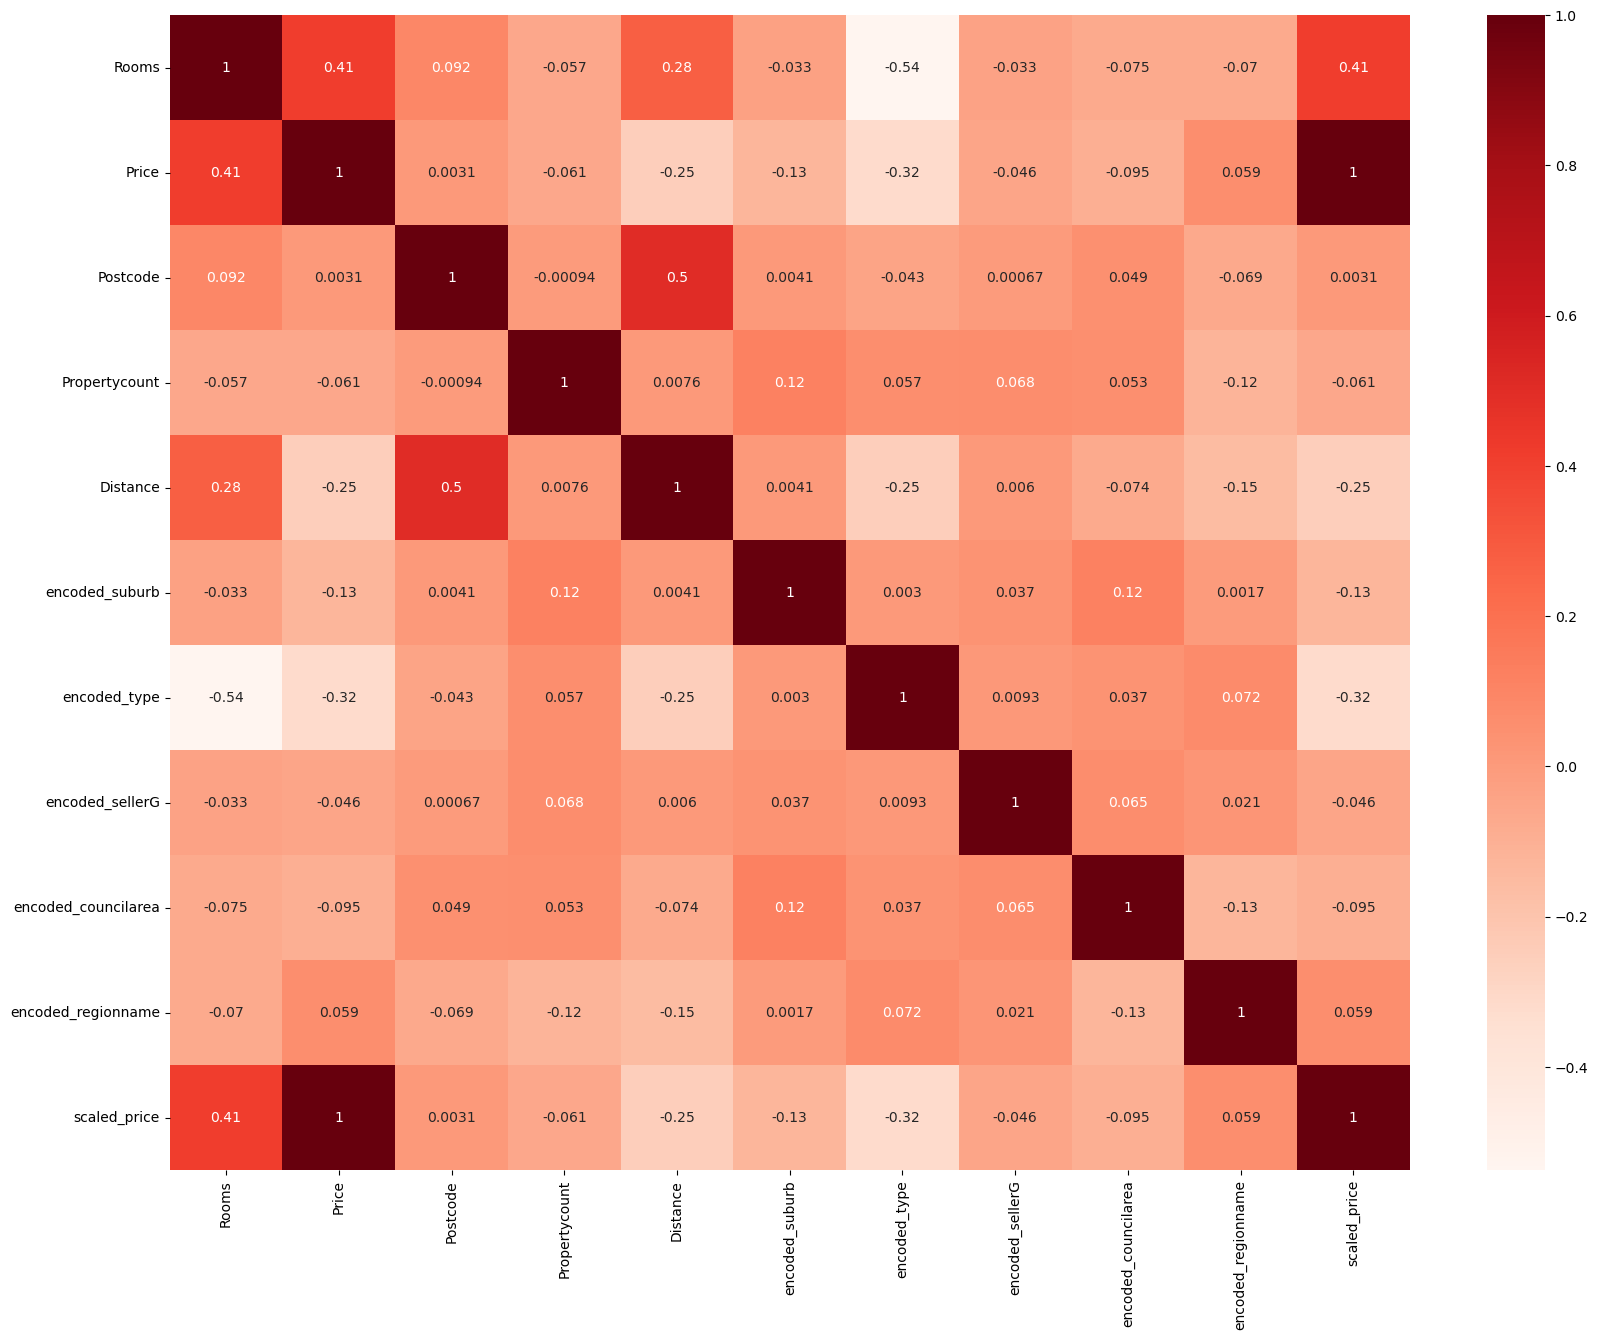

In [87]:
#Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [88]:
#figure out which variables contain missing data
df.isnull().sum()

#figure out relevant features, correlation > 0.2
cor_target = abs(cor["Price"])
selected_features = cor_target[cor_target>0.2]
selected_features

Rooms           0.412438
Price           1.000000
Distance        0.253668
encoded_type    0.317630
scaled_price    1.000000
Name: Price, dtype: float64

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

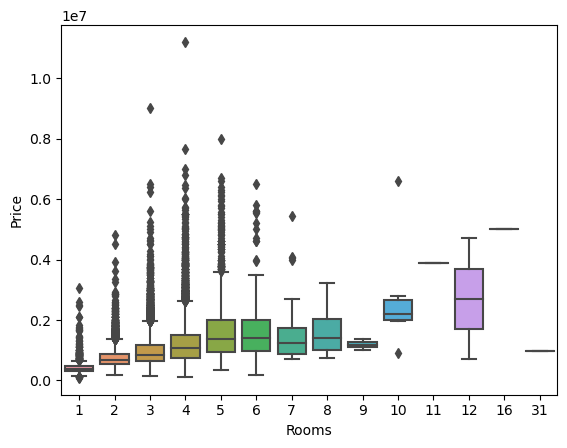

In [89]:
sns.boxplot(data = df, x='Rooms', y='Price')

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

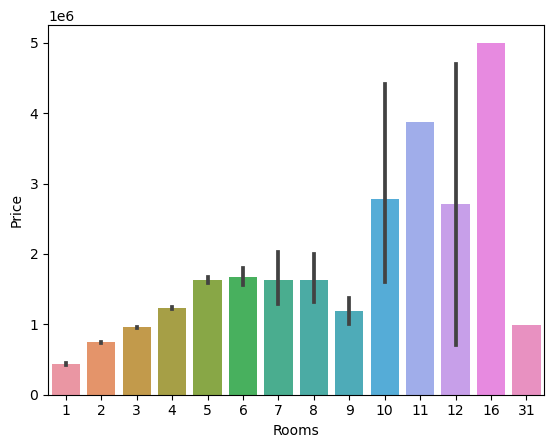

In [90]:
sns.barplot(data = df, x='Rooms', y='Price')

In [91]:
x = df[['Rooms', 'encoded_type']].copy()
y = df[['scaled_price']].copy()

#split into train and test 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 1)

#scale the data
x_train = scaler.fit_transform( x_train )
y_train = scaler.fit_transform( y_train )

In [98]:
from tensorflow.keras.layers import Dense, Dropout

#develop a deep neural net model
neurons = [16, 32, 40]
learn_rate = [0.001, 0.01, 0.1]
# dropout_rate = [0.0, 0.1, 0.2, 0.3]
dropout_rate = [0.05, 0.10, 0.15]


def create_model(neurons=1, dropout_rate=0.2, learn_rate=0.01):
    model = Sequential()
    model.add(Dense(13, input_dim=2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

dnnreg = KerasRegressor(neurons=neurons, learn_rate=learn_rate, dropout_rate=dropout_rate, build_fn=create_model, verbose=0)

C:\Users\Caesar\AppData\Local\Temp\ipykernel_26248\3779843500.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  dnnreg = KerasRegressor(neurons=neurons, learn_rate=learn_rate, dropout_rate=dropout_rate, build_fn=create_model, verbose=0)


In [102]:
def create_model(neurons=1, dropout_rate=0.0, learn_rate=0.01):
    model = Sequential()
    model.add(Dense(13, input_dim=2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

dnnreg = KerasRegressor(build_fn=create_model, verbose=0)

C:\Users\Caesar\AppData\Local\Temp\ipykernel_26248\3432548965.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  dnnreg = KerasRegressor(build_fn=create_model, verbose=0)


In [103]:


batch_size = [20, 40, 60]
epochs = [10, 50]
neurons = [16, 32, 40]
dropout_rate = [0.0, 0.1, 0.2, 0.3]
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(batch_size=batch_size, epochs=epochs, neurons = neurons,dropout_rate = dropout_rate, learn_rate=learn_rate)
search = RandomizedSearchCV(estimator=dnnreg, param_distributions=param_grid, n_jobs=-1, cv=3, scoring = "neg_mean_absolute_error")
search_resultReg = search.fit(x_train, y_train)
print("Best: %f using %s" % (search_resultReg.best_score_, search_resultReg.best_params_))

means = search_resultReg.cv_results_['mean_test_score']
stds = search_resultReg.cv_results_['std_test_score']
params = search_resultReg.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: -0.032125 using {'neurons': 32, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 20}
-0.032538 (0.000294) with: {'neurons': 40, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 60}
-0.032967 (0.000488) with: {'neurons': 32, 'learn_rate': 0.001, 'epochs': 10, 'dropout_rate': 0.3, 'batch_size': 40}
-0.032556 (0.000634) with: {'neurons': 32, 'learn_rate': 0.1, 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 60}
-0.032741 (0.000321) with: {'neurons': 40, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 40}
-0.032287 (0.000565) with: {'neurons': 40, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 60}
-0.032452 (0.000765) with: {'neurons': 32, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.0, 'batch_size': 20}
-0.032682 (0.000534) with: {'neurons': 32, 'learn_rate': 0.001, 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 60}
-0.032163 (0.000480) with: {'neurons': 40, 'learn_rate': 0.001, 'epochs':

In [104]:
import joblib 

joblib.dump(search_resultReg, 'DNNregressor.pkl')


INFO:tensorflow:Assets written to: C:\Users\Caesar\AppData\Local\Temp\tmp0d3ko7mc\assets


INFO:tensorflow:Assets written to: C:\Users\Caesar\AppData\Local\Temp\tmp0d3ko7mc\assets


['DNNregressor.pkl']

In [105]:
batch_size = [20, 40, 60]
epochs = [10, 50]
neurons = [16, 32, 40]
dropout_rate = [0.0, 0.1, 0.2, 0.3]
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(batch_size=batch_size, epochs=epochs, neurons = neurons,dropout_rate = dropout_rate, learn_rate=learn_rate)
search = RandomizedSearchCV(estimator=dnnreg, param_distributions=param_grid, n_jobs=-1, cv=3)
search_resultReg = search.fit(x_train, y_train)
print("Best: %f using %s" % (search_resultReg.best_score_, search_resultReg.best_params_))

means = search_resultReg.cv_results_['mean_test_score']
stds = search_resultReg.cv_results_['std_test_score']
params = search_resultReg.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.002313 using {'neurons': 40, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 60}
-0.002313 (0.000128) with: {'neurons': 40, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 60}
-0.002374 (0.000109) with: {'neurons': 32, 'learn_rate': 0.1, 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 20}
-0.002350 (0.000160) with: {'neurons': 40, 'learn_rate': 0.1, 'epochs': 10, 'dropout_rate': 0.0, 'batch_size': 40}
-0.002329 (0.000105) with: {'neurons': 40, 'learn_rate': 0.1, 'epochs': 10, 'dropout_rate': 0.0, 'batch_size': 20}
-0.002338 (0.000128) with: {'neurons': 40, 'learn_rate': 0.1, 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 20}
-0.002356 (0.000131) with: {'neurons': 32, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 40}
-0.002331 (0.000126) with: {'neurons': 40, 'learn_rate': 0.01, 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 40}
-0.002368 (0.000111) with: {'neurons': 40, 'learn_rate': 0.001, 'epochs': 10, '

In [106]:
search_resultReg.score(x_train, y_train)

-0.002299582352861762

In [107]:


kfold5 = KFold(n_splits=5, random_state=1, shuffle=True)                        
dnn_tuned = KerasRegressor(build_fn=create_model, verbose=0, epochs = 50, batch_size = 20, learn_rate = 0.01)

dnn_tuned.fit(x_train, y_train)



C:\Users\Caesar\AppData\Local\Temp\ipykernel_26248\3076031264.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  dnn_tuned = KerasRegressor(build_fn=create_model, verbose=0, epochs = 50, batch_size = 20, learn_rate = 0.01)


In [108]:
MAE_dnn = cross_val_score(dnn_tuned, x, y, scoring='neg_mean_absolute_error',cv = kfold5, n_jobs=-1)
RMSE_dnn = cross_val_score(dnn_tuned, x, y, scoring='neg_root_mean_squared_error',cv = kfold5, n_jobs=-1)
MSE_dnn = cross_val_score(dnn_tuned, x, y, scoring='neg_mean_squared_error',cv = kfold5, n_jobs=-1)
Rsquared_dnn = cross_val_score(dnn_tuned, x, y, scoring='r2',cv = kfold5, n_jobs=-1)

In [109]:
MAE_dnn
RMSE_dnn
MSE_dnn
Rsquared_dnn

array([0.17941625, 0.1883352 , 0.19215573, 0.18450439, 0.16560185])